In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns


# Set random seed for reproducibility
np.random.seed(42)


# Constants for sensor readings
DRY_SOIL_READING = 44000  # Maximum reading for dry soil (very dry)
SATURATED_SOIL_READING = 5000  # Minimum reading for saturated soil (very wet)

# Simulation parameters
num_days = 100
noise_level = 500

In [2]:
# Function to simulate weather pattern
def simulate_weather_pattern(num_days):
    """
    Simulate weather patterns based on the attached image:
    - sunny: dries the soil (increases sensor reading)
    - cloudy: soil moisture stays constant
    - rainy: wets the soil (decreases sensor reading)

    Returns:
    - weather conditions and precipitation amounts
    """
    # Generate weather types: c = cloudy, r = rainy, s = sunny
    weather_types = np.random.choice(['c', 'r', 's'], size=num_days, p=[0.3, 0.4, 0.3])

    # Generate precipitation data (X values) - positive values only
    X = np.maximum(0, np.random.normal(100, 5, num_days) * 2)  # Scale by 2 for more variation

    # Adjust precipitation based on weather type
    for i in range(num_days):
        if weather_types[i] == 'c':  # Cloudy - low precipitation
            X[i] = X[i] * 0.2
        elif weather_types[i] == 's':  # Sunny - no precipitation
            X[i] = 0

    return weather_types, X

In [3]:
# Function to simulate sensor readings based on weather and precipitation
def simulate_sensor_readings(weather_types, precipitation, initial_reading=30000, evaporation_factor=0.05):
    """
    Simulate sensor readings based on weather conditions:
    - Rain: Decreases sensor reading (soil gets wetter)
    - Sun: Increases sensor reading (soil dries)
    - Cloudy: Minimal change

    Returns:
    - Simulated sensor readings and delta values
    """
    sensor_readings = np.zeros(len(weather_types))
    sensor_readings[0] = initial_reading

    # Track sensor reading changes
    delta_readings = np.zeros(len(weather_types))

    for i in range(1, len(weather_types)):
        # Previous day's reading
        prev_reading = sensor_readings[i-1]

        # Default change (evaporation effect - soil naturally dries)
        natural_change = prev_reading * evaporation_factor

        # Weather-specific changes
        if weather_types[i] == 'r':  # Rainy
            # Rain decreases reading (makes soil wetter)
            # Higher precipitation causes greater decrease
            precip_effect = precipitation[i] * 50  # Scale factor
            change = -precip_effect + np.random.normal(0, noise_level)
        elif weather_types[i] == 's':  # Sunny
            # Sun increases reading (dries soil)
            change = natural_change + np.random.normal(0, noise_level)
        else:  # Cloudy
            # Cloudy days have minimal change
            change = np.random.normal(0, noise_level/2)

        # Calculate new reading
        new_reading = prev_reading + change

        # Ensure reading stays within sensor range
        new_reading = max(SATURATED_SOIL_READING, min(DRY_SOIL_READING, new_reading))

        # Store the values
        sensor_readings[i] = new_reading
        delta_readings[i] = change

    return sensor_readings, delta_readings

In [4]:

# Simulate weather and precipitation
weather_types, precipitation = simulate_weather_pattern(num_days)

# Simulate sensor readings
sensor_readings, delta_readings = simulate_sensor_readings(weather_types, precipitation)

# Create a dataframe with all simulation data
data = pd.DataFrame({
    'day': range(1, num_days + 1),
    'weather_type': weather_types,
    'precipitation': precipitation,
    'sensor_reading': sensor_readings,
    'delta_reading': delta_readings
})

# Calculate next-day sensor reading difference for modeling
data['next_day_delta'] = data['sensor_reading'].diff().shift(-1)

# Remove the last row which will have NaN for next_day_delta
data = data.iloc[:-1].copy()

# Print summary statistics
print("Data Summary Statistics:")
print(data.describe())

Data Summary Statistics:
             day  precipitation  sensor_reading  delta_reading  next_day_delta
count  99.000000      99.000000       99.000000      99.000000       99.000000
mean   50.000000      85.311173     8261.691932   -3327.833755     -252.525253
std    28.722813      86.965528     6922.253848    4891.387323     1801.933367
min     1.000000       0.000000     5000.000000  -11635.029752    -9354.516991
25%    25.500000       0.000000     5000.000000   -9373.486555     -111.291798
50%    50.000000      40.714225     5054.114647    -162.900087        0.000000
75%    74.500000     191.878481     6091.272362     201.425319      201.425319
max    99.000000     218.861859    33808.593032    2302.092086     2302.092086


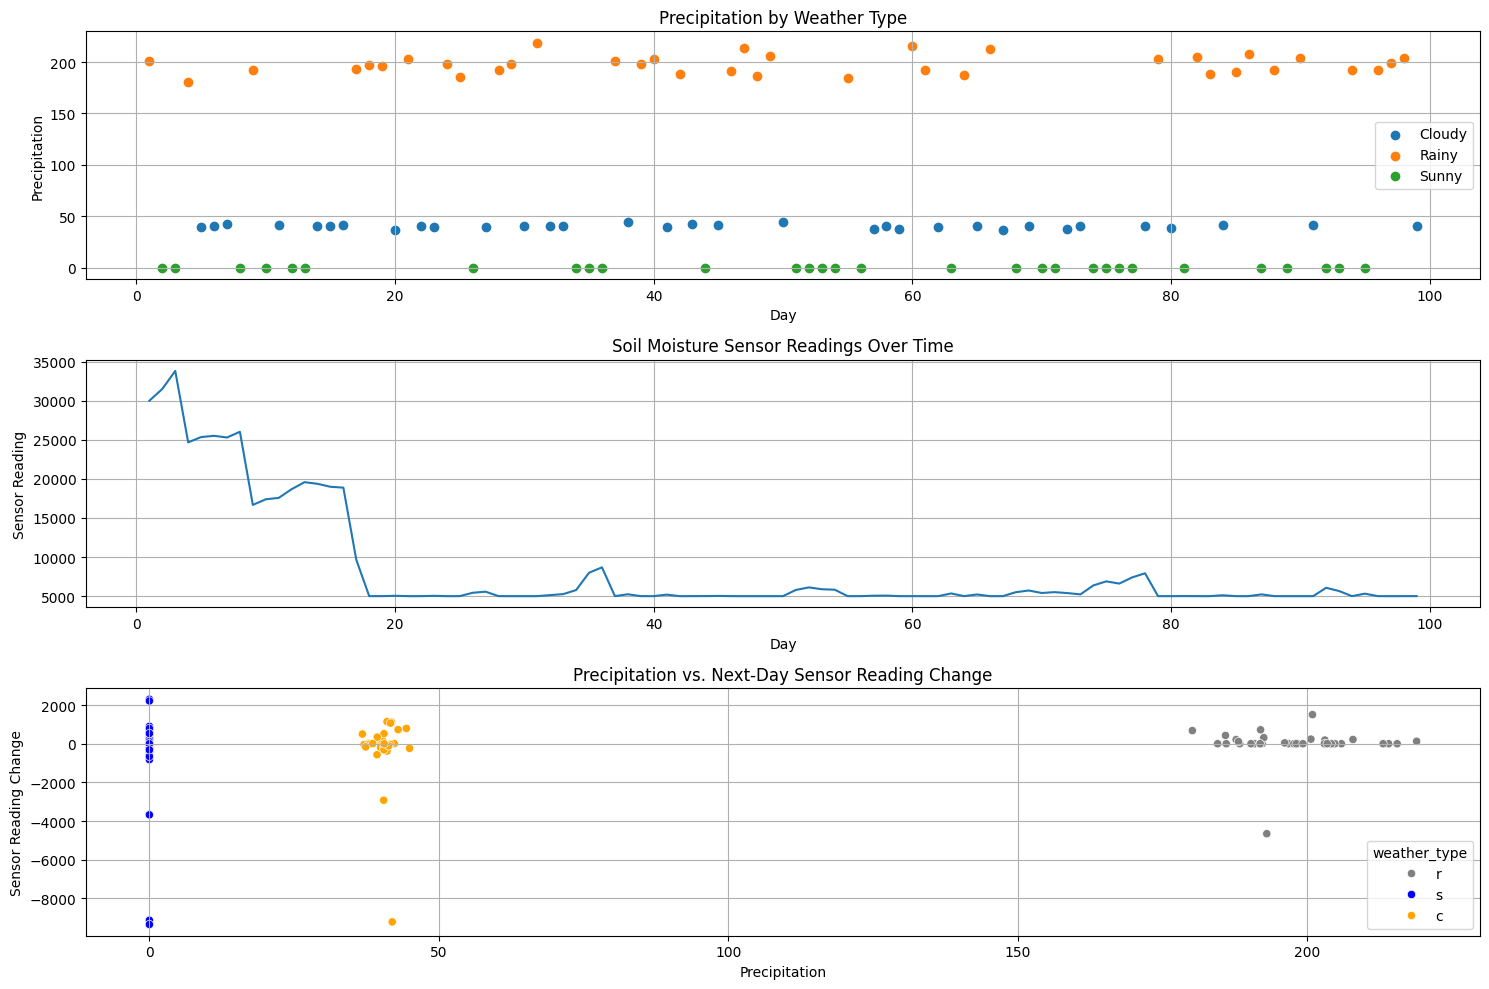

In [7]:

# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Weather type and precipitation
plt.subplot(3, 1, 1)
for i, weather in enumerate(['c', 'r', 's']):
    mask = data['weather_type'] == weather
    plt.scatter(data.loc[mask, 'day'], data.loc[mask, 'precipitation'],
               label=f"{'Cloudy' if weather=='c' else 'Rainy' if weather=='r' else 'Sunny'}")

plt.title('Precipitation by Weather Type')
plt.xlabel('Day')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)

# Plot 2: Sensor readings over time
plt.subplot(3, 1, 2)
plt.plot(data['day'], data['sensor_reading'])
plt.title('Soil Moisture Sensor Readings Over Time')
plt.xlabel('Day')
plt.ylabel('Sensor Reading')
plt.grid(True)

# Plot 3: Relationship between precipitation and sensor reading changes
plt.subplot(3, 1, 3)
sns.scatterplot(x='precipitation', y='next_day_delta', hue='weather_type',
               data=data, palette=['gray', 'blue', 'orange'])
plt.title('Precipitation vs. Next-Day Sensor Reading Change')
plt.xlabel('Precipitation')
plt.ylabel('Sensor Reading Change')
plt.grid(True)

plt.tight_layout()
plt.show()

# Build a linear regression model to predict precipitation from sensor changes
# We'll use only rainy days for training the model
rainy_data = data[data['weather_type'] == 'r'].copy()



Linear Regression Model Results:
Coefficient: 0.000288
Intercept: 197.522191
RMSE: 9.1673
R²: 0.0007


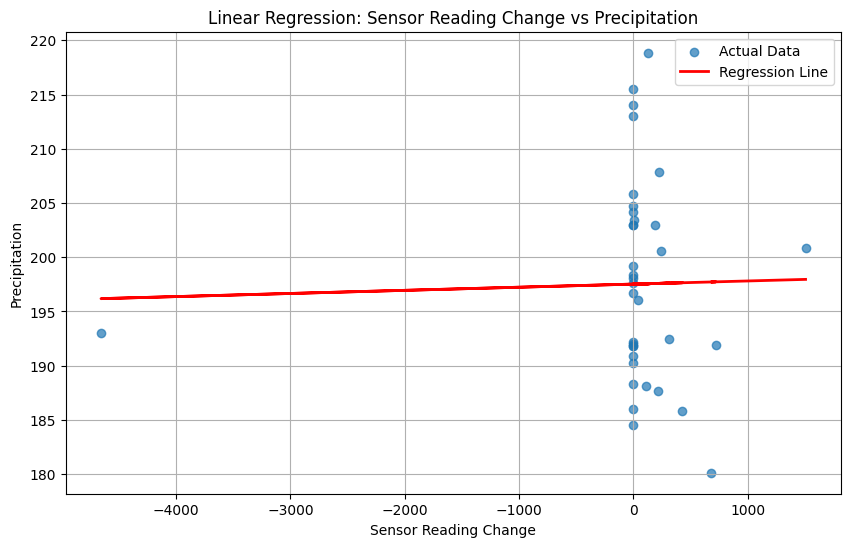


Prediction Test:
Sensor delta: -5000, Predicted precipitation: 196.08
Sensor delta: -3000, Predicted precipitation: 196.66
Sensor delta: -1000, Predicted precipitation: 197.23
Sensor delta: 0, Predicted precipitation: 197.52
Sensor delta: 1000, Predicted precipitation: 197.81


In [8]:

# Prepare X and y
X_train = rainy_data['next_day_delta'].values.reshape(-1, 1)  # Sensor reading change
y_train = rainy_data['precipitation'].values  # Actual precipitation

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_train)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
r2 = r2_score(y_train, y_pred)

print(f"\nLinear Regression Model Results:")
print(f"Coefficient: {model.coef_[0]:.6f}")
print(f"Intercept: {model.intercept_:.6f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.7, label='Actual Data')
plt.plot(X_train, y_pred, color='red', linewidth=2, label='Regression Line')
plt.title('Linear Regression: Sensor Reading Change vs Precipitation')
plt.xlabel('Sensor Reading Change')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)
plt.show()

# Function to predict precipitation based on sensor reading change
def predict_precipitation(sensor_delta):
    """
    Predict precipitation amount based on sensor reading change

    Parameters:
    sensor_delta: Change in sensor reading (current - previous)

    Returns:
    Predicted precipitation amount
    """
    # Convert input to appropriate format
    if isinstance(sensor_delta, (int, float)):
        sensor_delta = np.array([[sensor_delta]])
    else:
        sensor_delta = np.array(sensor_delta).reshape(-1, 1)

    # Make prediction
    return model.predict(sensor_delta)

# Test the prediction function
test_deltas = [-5000, -3000, -1000, 0, 1000]
predicted_precip = [predict_precipitation(delta)[0] for delta in test_deltas]

# Print test results
print("\nPrediction Test:")
for delta, precip in zip(test_deltas, predicted_precip):
    print(f"Sensor delta: {delta}, Predicted precipitation: {max(0, precip):.2f}")


In [18]:

# Prepare X and y
X_train1 = data['next_day_delta'].values.reshape(-1, 1)  # Sensor reading change
y_train1 = data['precipitation'].values  # Actual precipitation

# Create and train the model
model = LinearRegression()
model.fit(X_train1, y_train1)

# Make predictions
y_pred1 = model.predict(X_train1)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_train1, y_pred1))
r2 = r2_score(y_train1, y_pred1)

print(f"\nLinear Regression Model Results:")
print(f"Coefficient: {model.coef_[0]:.6f}")
print(f"Intercept: {model.intercept_:.6f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Linear Regression Model Results:
Coefficient: 0.005740
Intercept: 86.760578
RMSE: 85.9111
R²: 0.0141


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.392
Date:                Wed, 02 Apr 2025   Prob (F-statistic):              0.241
Time:                        19:18:09   Log-Likelihood:                -581.35
No. Observations:                  99   AIC:                             1167.
Df Residuals:                      97   BIC:                             1172.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.7606      8.809      9.849      0.0

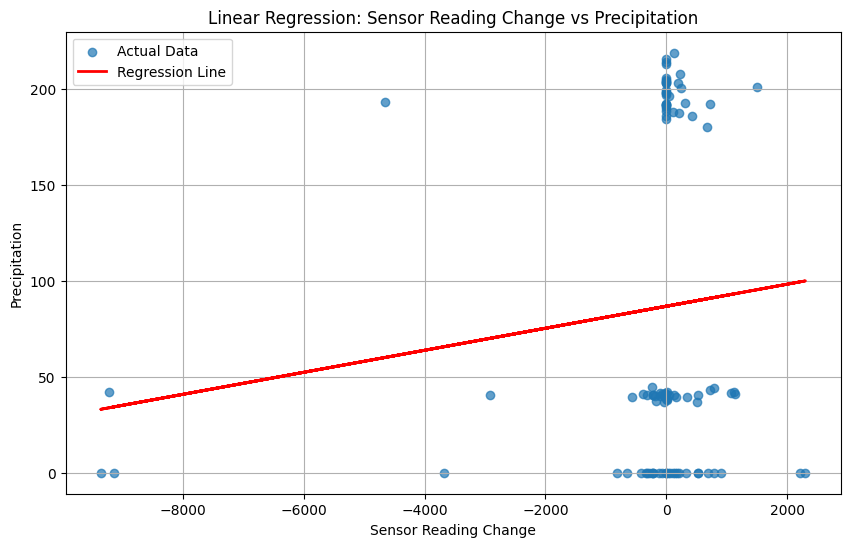

In [26]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# Prepare X and y
X_train = data['next_day_delta'].values  # Sensor reading change
y_train = data['precipitation'].values  # Actual precipitation

# Add constant term for intercept
X_train_const = sm.add_constant(X_train)

# Create and train the model
model = sm.OLS(y_train, X_train_const).fit()

# Make predictions
y_pred = model.predict(X_train_const)

# Evaluate the model
rmse = np.sqrt(np.mean((y_train - y_pred) ** 2))
r2 = model.rsquared

# Print model summary
print(model.summary())

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.7, label='Actual Data')  # Use 1D X_train (without constant)
plt.plot(X_train, y_pred, color='red', linewidth=2, label='Regression Line')
plt.title('Linear Regression: Sensor Reading Change vs Precipitation')
plt.xlabel('Sensor Reading Change')
plt.ylabel('Precipitation')
plt.legend()
plt.grid(True)
plt.show()
